In [44]:
from scripts import save_measurement as sm
import ffmpeg
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pyPPG
import pyPPG.datahandling as ppgdata
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
from dotmap import DotMap
from tkinter import filedialog
import mne
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
import tkinter as tk
from tkinter import simpledialog
from scipy.io import savemat
import glob
import os

from pyPPG import PPG, Fiducials, Biomarkers
from pyPPG.datahandling import load_data, plot_fiducials, save_data
import pyPPG.preproc as PP
import pyPPG.fiducials as FP
import pyPPG.biomarkers as BM
import pyPPG.ppg_sqi as SQI

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from sklearn.model_selection import train_test_split
import keras
import seaborn as sns


In [51]:
def create_dotmap(sig,fs, rec_name,start_sig=0, end_sig=-1):
    s = DotMap()

    s.start_sig = start_sig
    if start_sig<end_sig:
        s.end_sig = end_sig
    else:
        s.end_sig = len(sig)

    try:
        print("This code is executing")
        s.v=sig[s.start_sig:s.end_sig]
    except:
        raise('There is no valid PPG signal!')

    s.fs=fs
    s.name=rec_name

    return s

In [2]:
video_file_path = r'recording\iphone-recording-sample.MOV'
probe=ffmpeg.probe(video_file_path)
video_info=next(stream for stream in probe['streams'] if stream['codec_type']=='video')
width=int(video_info['width'])
height = int(video_info['height'])
num_frames = int(video_info['nb_frames'])
print(video_info)

{'index': 0, 'codec_name': 'h264', 'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', 'profile': 'High', 'codec_type': 'video', 'codec_tag_string': 'avc1', 'codec_tag': '0x31637661', 'width': 1920, 'height': 1080, 'coded_width': 1920, 'coded_height': 1080, 'closed_captions': 0, 'film_grain': 0, 'has_b_frames': 0, 'pix_fmt': 'yuv420p', 'level': 40, 'color_range': 'tv', 'color_space': 'bt709', 'color_transfer': 'bt709', 'color_primaries': 'bt709', 'chroma_location': 'left', 'field_order': 'progressive', 'refs': 1, 'is_avc': 'true', 'nal_length_size': '4', 'id': '0x1', 'r_frame_rate': '30000/1001', 'avg_frame_rate': '1086000/36227', 'time_base': '1/600', 'start_pts': 0, 'start_time': '0.000000', 'duration_ts': 36227, 'duration': '60.378333', 'bit_rate': '315782', 'bits_per_raw_sample': '8', 'nb_frames': '1810', 'extradata_size': 174, 'disposition': {'default': 1, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impa

In [62]:
video_file_path = r'C:\Users\rehma\OneDrive\Desktop\ppg-signal-extraction-master\data\iphone-recording-sample.MOV'

vc = cv2.VideoCapture(video_file_path)
fps=vc.get(cv2.CAP_PROP_FPS)
frame_interval = int(fps*0.1)
print(fps)
rframes = []
start_frame=(int(vc.get(cv2.CAP_PROP_FRAME_COUNT)))//2

vc.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
while True: 
    if not vc.grab():
        break
    


    if int(vc.get(cv2.CAP_PROP_POS_FRAMES))%frame_interval==0:
        ret, frame = vc.retrieve()
        
        if not ret:
            break
        
        red_channel = frame[:,:,2]
        rframes.append(red_channel)

vc.release()


29.977640986004914


In [64]:
processed_frames = [np.mean(frames) for frames in rframes]

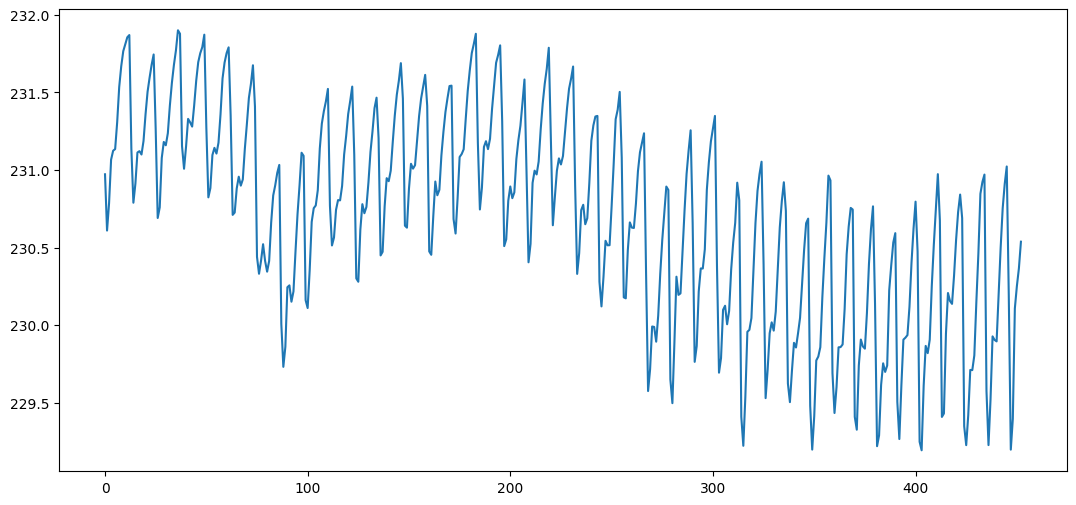

In [65]:
fig = plt.figure(figsize=(13, 6))
ax = plt.axes()
ax.plot(list(range(len(processed_frames))), processed_frames)
plt.show()

In [66]:
signal = create_dotmap(processed_frames,10,'Signal1')

This code is executing


In [67]:
print(signal.v)

[230.9723230131173, 230.60951822916667, 230.786434220679, 231.06689718364197, 231.12413483796297, 231.13493682484568, 231.30808449074075, 231.53513695987655, 231.66873119212963, 231.7661656057099, 231.80974633487654, 231.85570842978396, 231.87011766975309, 231.13660783179012, 230.7890692515432, 230.91287422839505, 231.11298321759259, 231.12147424768517, 231.09992332175926, 231.18714023919753, 231.35924527391975, 231.50432339891975, 231.59556905864198, 231.6781394675926, 231.74484567901234, 231.2661222029321, 230.69059124228394, 230.75922357253086, 231.07756799768518, 231.18093026620372, 231.15940441743828, 231.237198591821, 231.4152097800926, 231.56173032407406, 231.6773331404321, 231.7714530285494, 231.90092881944443, 231.8785614390432, 231.1547839506173, 231.00804928626542, 231.15226996527778, 231.3296730324074, 231.30750096450618, 231.27985677083333, 231.41683111496914, 231.57541039737654, 231.695206404321, 231.75293451003085, 231.7919849537037, 231.87253568672838, 231.2746735146605

In [68]:
signal.filtering = True # whether or not to filter the PPG signal
signal.fL=0.5000001 # Lower cutoff frequency (Hz)
signal.fH=4.9 # Upper cutoff frequency (Hz)
signal.order=4 # Filter order
signal.sm_wins={'ppg':50,'vpg':10,'apg':10,'jpg':10} # smoothing windows in millisecond for the PPG, PPG', PPG", and PPG'"

prep = PP.Preprocess(fL=signal.fL, fH=signal.fH, order=signal.order, sm_wins=signal.sm_wins)
signal.ppg, signal.vpg, signal.apg, signal.jpg = prep.get_signals(s=signal)

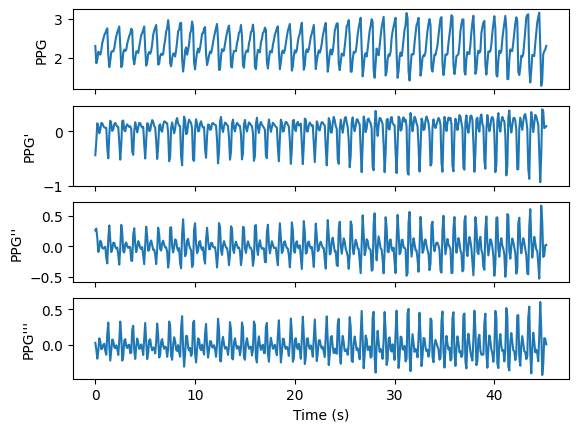

In [69]:
# setup figure
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, sharey = False)

# create time vector
t = np.arange(0, len(signal.ppg))/signal.fs

# plot filtered PPG signal
ax1.plot(t, signal.ppg)
ax1.set(xlabel = '', ylabel = 'PPG')

# plot first derivative
ax2.plot(t, signal.vpg)
ax2.set(xlabel = '', ylabel = 'PPG\'')

# plot second derivative
ax3.plot(t, signal.apg)
ax3.set(xlabel = '', ylabel = 'PPG\'\'')

# plot third derivative
ax4.plot(t, signal.jpg)
ax4.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'\'')

# show plot
plt.show()
